#UIDAI BIOMETRIC LIFECYCLE ANALYSIS

#### CELL 1: SETUP AND INSTALLATIONS

In [1]:
print("="*80)
print("STEP 0: INSTALLING REQUIRED PACKAGES")
print("="*80)

import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy -q

print("✓ All packages installed successfully!\n")

STEP 0: INSTALLING REQUIRED PACKAGES
✓ All packages installed successfully!



### CELL 2: IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure display and plotting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*80)
print("✓ Libraries imported successfully")
print("="*80)

✓ Libraries imported successfully


# CELL 3: UPLOAD DATA FILE, LOAD AND VALIDATE DATA


In [4]:
import pandas as pd
from google.colab import files
import zipfile

print("\n" + "="*80)
print("STEP 1: UPLOAD YOUR BIOMETRIC DATA FILE")
print("="*80)
print("\nPlease upload: data_final_cleaned_biom.zip")
print("(Click 'Choose Files' button that appears below)\n")

# Upload ZIP
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {zip_name}")

print("\n" + "="*80)
print("STEP 2: LOADING AND VALIDATING BIOMETRIC DATA")
print("="*80)

# Open ZIP and auto-detect CSV (ignore __MACOSX)
with zipfile.ZipFile(zip_name, 'r') as z:
    print("Files inside ZIP:", z.namelist())

    csv_files = [
        f for f in z.namelist()
        if f.lower().endswith(".csv") and "__macosx" not in f.lower()
    ]

    if len(csv_files) != 1:
        raise ValueError(f"Expected 1 CSV, found {len(csv_files)}: {csv_files}")

    csv_name = csv_files[0]
    print(f"✓ Using CSV file: {csv_name}")

    with z.open(csv_name) as f:
        df = pd.read_csv(f)

# Date handling
df['date'] = pd.to_datetime(df['date'])

# Add year_month if not present
if 'year_month' not in df.columns:
    df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Validation summary
print(f"\n✓ Data loaded successfully!")
print(f"  - Total records: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"  - Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  - States: {df['state'].nunique()}")
print(f"  - Districts: {df['district'].nunique()}")
print(f"  - Pincodes: {df['pincode'].nunique()}")
print(f"  - Total biometric captures: {df['total_biometric'].sum():,}")

print("\nFirst few rows:")
display(df.head())


STEP 1: UPLOAD YOUR BIOMETRIC DATA FILE

Please upload: data_final_cleaned_biom.zip
(Click 'Choose Files' button that appears below)



Saving data_final_cleaned_biom.csv.zip to data_final_cleaned_biom.csv (1).zip

✓ File uploaded: data_final_cleaned_biom.csv (1).zip

STEP 2: LOADING AND VALIDATING BIOMETRIC DATA
Files inside ZIP: ['data_final_cleaned_biom.csv', '__MACOSX/._data_final_cleaned_biom.csv']
✓ Using CSV file: data_final_cleaned_biom.csv

✓ Data loaded successfully!
  - Total records: 1,861,108
  - Total columns: 20
  - Date range: 2025-03-01 to 2025-12-29
  - States: 36
  - Districts: 945
  - Pincodes: 19707
  - Total biometric captures: 69,763,095

First few rows:


,date,state,district,pincode,bio_age_5_17,bio_age_17_above,state_original,district_original,pincode_original,pincode_valid,geo_flag,date_original,has_negative_age,total_biometric,has_extreme_value,pct_age_5_17,pct_age_17_above,age_flag,exclude_from_analysis,year_month
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,Haryana,Mahendragarh,123029,True,False,01-03-2025,False,857,True,32.672112,67.327888,False,False,2025-03
1,2025-03-01,Bihar,Madhepura,852121,144,369,Bihar,Madhepura,852121,True,False,01-03-2025,False,513,True,28.070175,71.929825,False,False,2025-03
2,2025-03-01,Jammu and Kashmir,Poonch,185101,643,1091,Jammu and Kashmir,Punch,185101,True,False,01-03-2025,False,1734,True,37.081892,62.918108,False,False,2025-03
3,2025-03-01,Bihar,Bhojpur,802158,256,980,Bihar,Bhojpur,802158,True,False,01-03-2025,False,1236,True,20.711974,79.288026,False,False,2025-03
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,Tamil Nadu,Madurai,625514,True,False,01-03-2025,False,1086,True,24.953959,75.046041,False,False,2025-03


### CELL 4: ADD DERIVED FEATURES

In [7]:
print("\n" + "="*80)
print("STEP 3: CREATING DERIVED BIOMETRIC FEATURES")
print("="*80)

# Temporal features
df['day_of_week'] = df['date'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

# Batch size categories
df['batch_size_category'] = pd.cut(
    df['total_biometric'],
    bins=[0, 5, 20, 100, np.inf],
    labels=['Small (1-5)', 'Medium (6-20)', 'Large (21-100)', 'Mega (100+)']
)

# Age dominance
df['dominant_age'] = 'Adult'
df.loc[df['bio_age_5_17'] > df['bio_age_17_above'], 'dominant_age'] = 'Youth'
df.loc[df['bio_age_5_17'] == df['bio_age_17_above'], 'dominant_age'] = 'Equal'

# Pure age batches
df['is_pure_youth'] = (df['bio_age_5_17'] > 0) & (df['bio_age_17_above'] == 0)
df['is_pure_adult'] = (df['bio_age_17_above'] > 0) & (df['bio_age_5_17'] == 0)
df['is_mixed_age'] = (df['bio_age_5_17'] > 0) & (df['bio_age_17_above'] > 0)

print("✓ Created derived features:")
print("  - day_of_week, is_weekend")
print("  - batch_size_category (4 levels)")
print("  - dominant_age (Youth/Adult/Equal)")
print("  - is_pure_youth, is_pure_adult, is_mixed_age")


STEP 3: CREATING DERIVED BIOMETRIC FEATURES
✓ Created derived features:
  - day_of_week, is_weekend
  - batch_size_category (4 levels)
  - dominant_age (Youth/Adult/Equal)
  - is_pure_youth, is_pure_adult, is_mixed_age


### CELL 5: KEY HEADLINE NUMBERS

In [8]:
print("\n" + "="*80)
print(" KEY BIOMETRIC FINDINGS")
print("="*80)

overall_youth_pct = df['pct_age_5_17'].mean()
overall_adult_pct = df['pct_age_17_above'].mean()

print(f"\n FINDING 1: YOUTH BIOMETRIC DOMINANCE")
print(f"  Youth (5-17): {overall_youth_pct:.1f}% of all biometric captures")
print(f"  Adult (17+): {overall_adult_pct:.1f}% of all biometric captures")
print(f"  → Youth 4.3x more visible than in demographic updates (11%)")

# Batch size
small_pct = (df['total_biometric'] <= 5).sum() / len(df) * 100
large_pct = (df['total_biometric'] > 100).sum() / len(df) * 100

print(f"\n FINDING 2: DUAL SERVICE MODEL")
print(f"  Small batches (1-5): {small_pct:.1f}%")
print(f"  Large/Mega (100+): {large_pct:.1f}%")
print(f"  → Both walk-in and camp infrastructure essential")

# Weekend pattern
weekend_youth = df[df['is_weekend']]['pct_age_5_17'].mean()
weekday_youth = df[~df['is_weekend']]['pct_age_5_17'].mean()
weekend_surplus = weekend_youth - weekday_youth

print(f"\n FINDING 3: WEEKEND FAMILY CLUSTERING")
print(f"  Weekend youth: {weekend_youth:.1f}%")
print(f"  Weekday youth: {weekday_youth:.1f}%")
print(f"  Weekend surplus: {weekend_surplus:+.1f} percentage points")
print(f"  → School-day barrier forces weekend family visits")

# September shift
pre_sep = df[df['year_month'].isin(['2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])]
post_sep = df[df['year_month'].isin(['2025-09', '2025-10', '2025-11', '2025-12'])]

if len(pre_sep) > 0:
    youth_shift = post_sep['pct_age_5_17'].mean() - pre_sep['pct_age_5_17'].mean()
    volume_shift = len(post_sep) / len(pre_sep)

    print(f"\n FINDING 4: SEPTEMBER SCHOOL-SEASON SURGE")
    print(f"  Volume increase: {volume_shift:.1f}x")
    print(f"  Youth shift: {youth_shift:+.1f} percentage points")
    print(f"  → School admission deadlines drive biometric verification rush")


 KEY BIOMETRIC FINDINGS

 FINDING 1: YOUTH BIOMETRIC DOMINANCE
  Youth (5-17): 47.3% of all biometric captures
  Adult (17+): 52.7% of all biometric captures
  → Youth 4.3x more visible than in demographic updates (11%)

 FINDING 2: DUAL SERVICE MODEL
  Small batches (1-5): 41.0%
  Large/Mega (100+): 5.9%
  → Both walk-in and camp infrastructure essential

 FINDING 3: WEEKEND FAMILY CLUSTERING
  Weekend youth: 48.8%
  Weekday youth: 46.7%
  Weekend surplus: +2.0 percentage points
  → School-day barrier forces weekend family visits

 FINDING 4: SEPTEMBER SCHOOL-SEASON SURGE
  Volume increase: 16.0x
  Youth shift: +1.3 percentage points
  → School admission deadlines drive biometric verification rush


### CELL 6: BATCH SIZE vs YOUTH COMPOSITION

In [9]:
print("\n" + "="*80)
print(" INSIGHT 1: BATCH SIZE vs YOUTH % (School Camp Sweet Spot)")
print("="*80)

age_by_batch = df.groupby('batch_size_category').agg({
    'pct_age_5_17': 'mean',
    'pct_age_17_above': 'mean',
    'total_biometric': ['count', 'sum']
}).round(1)

age_by_batch.columns = ['Avg_%_Youth', 'Avg_%_Adult', 'Num_Batches', 'Total_People']
print(age_by_batch)

large_youth = age_by_batch.loc['Large (21-100)', 'Avg_%_Youth']
small_youth = age_by_batch.loc['Small (1-5)', 'Avg_%_Youth']
mega_youth = age_by_batch.loc['Mega (100+)', 'Avg_%_Youth']

print(f"\n→ BIOMETRIC SERVICE SIGNAL:")
print(f"  Small (1-5): {small_youth:.1f}% youth (family walk-ins)")
print(f"  Large (21-100): {large_youth:.1f}% youth ← PEAK EFFICIENCY")
print(f"  Mega (100+): {mega_youth:.1f}% youth (declines after 100)")

print(f"\n→ INTERPRETATION:")
print(f"  School camp sweet spot: 21-100 children per session")
print(f"  Optimal balance of logistics and youth capture efficiency")

print(f"\n→ UIDAI ACTION:")
print(f"  Standardize school camps at 25-75 child size")
print(f"  Avoid mega-camps (100+) - diminishing returns")


 INSIGHT 1: BATCH SIZE vs YOUTH % (School Camp Sweet Spot)
                     Avg_%_Youth  Avg_%_Adult  Num_Batches  Total_People
batch_size_category                                                     
Small (1-5)                 43.8         56.2       763886       1908430
Medium (6-20)               48.6         51.4       610615       6837425
Large (21-100)              51.8         48.2       377521      15784489
Mega (100+)                 48.5         51.5       109074      45232751

→ BIOMETRIC SERVICE SIGNAL:
  Small (1-5): 43.8% youth (family walk-ins)
  Large (21-100): 51.8% youth ← PEAK EFFICIENCY
  Mega (100+): 48.5% youth (declines after 100)

→ INTERPRETATION:
  School camp sweet spot: 21-100 children per session
  Optimal balance of logistics and youth capture efficiency

→ UIDAI ACTION:
  Standardize school camps at 25-75 child size
  Avoid mega-camps (100+) - diminishing returns


### CELL 7: WEEKEND vs WEEKDAY PATTERNS

In [10]:
print("\n" + "="*80)
print(" INSIGHT 2: WEEKEND FAMILY BIOMETRIC CLUSTERING")
print("="*80)

weekend_bio = df.groupby('is_weekend').agg({
    'pct_age_5_17': 'mean',
    'pct_age_17_above': 'mean',
    'total_biometric': ['sum', 'mean', 'count']
}).round(1)

weekend_bio.columns = ['Avg_%_Youth', 'Avg_%_Adult', 'Total_Captures', 'Avg_Batch', 'Num_Batches']
print(weekend_bio)

weekend_batch = df[df['is_weekend']]['total_biometric'].mean()
weekday_batch = df[~df['is_weekend']]['total_biometric'].mean()
batch_increase = (weekend_batch - weekday_batch) / weekday_batch * 100

print(f"\n→ BIOMETRIC ACCESS SIGNAL:")
print(f"  Weekend batch size: {weekend_batch:.1f} ({batch_increase:+.0f}% vs weekday)")
print(f"  Weekend youth surplus: {weekend_surplus:+.1f} percentage points")
print(f"  Weekend captures: {weekend_bio.loc[True, 'Total_Captures']:,.0f}")

print(f"\n→ INTERPRETATION:")
print(f"  School schedules force families to cluster biometric updates on weekends")
print(f"  Working parents can only bring children on non-school days")
print(f"  Larger batches = entire families processed together")

print(f"\n→ UIDAI ACTION:")
print(f"  Mandate weekend operations in all school-serving centers")
print(f"  Extended hours: Saturdays 8am-8pm, Sundays 10am-6pm")
print(f"  Family processing lanes for multi-member batches")


 INSIGHT 2: WEEKEND FAMILY BIOMETRIC CLUSTERING
            Avg_%_Youth  Avg_%_Adult  Total_Captures  Avg_Batch  Num_Batches
is_weekend                                                                  
False              46.7         53.3        47075023       34.6      1361771
True               48.8         51.2        22688072       45.4       499337

→ BIOMETRIC ACCESS SIGNAL:
  Weekend batch size: 45.4 (+31% vs weekday)
  Weekend youth surplus: +2.0 percentage points
  Weekend captures: 22,688,072

→ INTERPRETATION:
  School schedules force families to cluster biometric updates on weekends
  Working parents can only bring children on non-school days
  Larger batches = entire families processed together

→ UIDAI ACTION:
  Mandate weekend operations in all school-serving centers
  Extended hours: Saturdays 8am-8pm, Sundays 10am-6pm
  Family processing lanes for multi-member batches


### CELL 8: SEPTEMBER BIOMETRIC SHIFT

In [11]:
print("\n" + "="*80)
print(" INSIGHT 3: SEPTEMBER SCHOOL-LINKED SURGE")
print("="*80)

if len(pre_sep) > 0:
    print(f"\nPre-September (Mar-Jul):")
    print(f"  Records: {len(pre_sep):,}")
    print(f"  Avg batch: {pre_sep['total_biometric'].mean():.1f}")
    print(f"  Youth %: {pre_sep['pct_age_5_17'].mean():.1f}%")

    print(f"\nPost-September (Sep-Dec):")
    print(f"  Records: {len(post_sep):,}")
    print(f"  Avg batch: {post_sep['total_biometric'].mean():.1f}")
    print(f"  Youth %: {post_sep['pct_age_5_17'].mean():.1f}%")

    batch_shift = pre_sep['total_biometric'].mean() / post_sep['total_biometric'].mean()

    print(f"\n→ BIOMETRIC LIFECYCLE SIGNAL:")
    print(f"  {volume_shift:.1f}x volume increase")
    print(f"  {batch_shift:.1f}x batch size decrease")
    print(f"  {youth_shift:+.1f}% youth increase")

    print(f"\n→ INTERPRETATION:")
    print(f"  September = school admission biometric verification rush")
    print(f"  Distributed model scales better than camps")
    print(f"  Youth increase unique to biometric (not in demographic/enrolment)")

    print(f"\n→ UIDAI ACTION:")
    print(f"  Pre-September school camps (July-August proactive deployment)")
    print(f"  September capacity surge (temporary operators + extended hours)")
    print(f"  School MoU templates for streamlined partnerships")


 INSIGHT 3: SEPTEMBER SCHOOL-LINKED SURGE

Pre-September (Mar-Jul):
  Records: 109,703
  Avg batch: 387.7
  Youth %: 46.1%

Post-September (Sep-Dec):
  Records: 1,751,405
  Avg batch: 15.5
  Youth %: 47.4%

→ BIOMETRIC LIFECYCLE SIGNAL:
  16.0x volume increase
  24.9x batch size decrease
  +1.3% youth increase

→ INTERPRETATION:
  September = school admission biometric verification rush
  Distributed model scales better than camps
  Youth increase unique to biometric (not in demographic/enrolment)

→ UIDAI ACTION:
  Pre-September school camps (July-August proactive deployment)
  September capacity surge (temporary operators + extended hours)
  School MoU templates for streamlined partnerships


### CELL 9: GEOGRAPHIC YOUTH DISPARITY

In [12]:
print("\n" + "="*80)
print(" INSIGHT 4: GEOGRAPHIC YOUTH BIOMETRIC PRESSURE")
print("="*80)

state_youth = df.groupby('state')['pct_age_5_17'].mean().sort_values(ascending=False)

print(f"\nTop 10 states by youth biometric pressure:")
for i, (state, pct) in enumerate(state_youth.head(10).items(), 1):
    print(f"  {i}. {state}: {pct:.1f}%")

print(f"\nBottom 10 states (adult-dominated):")
for i, (state, pct) in enumerate(state_youth.tail(10).items(), 1):
    print(f"  {i}. {state}: {pct:.1f}%")

top_youth = state_youth.iloc[0]
bottom_youth = state_youth.iloc[-1]
disparity = top_youth / bottom_youth

print(f"\n→ GEOGRAPHIC BIOMETRIC SIGNAL:")
print(f"  Highest: {state_youth.index[0]} at {top_youth:.1f}%")
print(f"  Lowest: {state_youth.index[-1]} at {bottom_youth:.1f}%")
print(f"  Disparity: {disparity:.2f}x")

print(f"\n→ COMPARISON TO DEMOGRAPHIC:")
print(f"  Biometric disparity: {disparity:.2f}x")
print(f"  Demographic disparity: 3.7x")
print(f"  ✓ Biometric infrastructure MORE equitable than demographic")

print(f"\n→ UIDAI ACTION:")
print(f"  Maintain biometric equity (don't let disparity grow)")
print(f"  Replicate biometric inclusion model for demographic services")
print(f"  Target low-youth states for school partnership expansion")


 INSIGHT 4: GEOGRAPHIC YOUTH BIOMETRIC PRESSURE

Top 10 states by youth biometric pressure:
  1. Arunachal Pradesh: 64.4%
  2. Mizoram: 60.9%
  3. Uttar Pradesh: 60.3%
  4. Manipur: 59.2%
  5. Assam: 59.2%
  6. Telangana: 59.0%
  7. Ladakh: 56.1%
  8. Jammu and Kashmir: 56.0%
  9. Uttarakhand: 55.0%
  10. Goa: 54.6%

Bottom 10 states (adult-dominated):
  1. Puducherry: 40.8%
  2. Maharashtra: 40.7%
  3. Chhattisgarh: 40.2%
  4. Dadra and Nagar Haveli and Daman and Diu: 40.0%
  5. Jharkhand: 39.7%
  6. Bihar: 39.7%
  7. West Bengal: 37.6%
  8. Kerala: 37.6%
  9. Punjab: 37.5%
  10. Nagaland: 36.8%

→ GEOGRAPHIC BIOMETRIC SIGNAL:
  Highest: Arunachal Pradesh at 64.4%
  Lowest: Nagaland at 36.8%
  Disparity: 1.75x

→ COMPARISON TO DEMOGRAPHIC:
  Biometric disparity: 1.75x
  Demographic disparity: 3.7x
  ✓ Biometric infrastructure MORE equitable than demographic

→ UIDAI ACTION:
  Maintain biometric equity (don't let disparity grow)
  Replicate biometric inclusion model for demographic se

### CELL 10: DERIVED METRIC 1 - BRPI

In [13]:
print("\n" + "="*80)
print(" DERIVED METRIC 1: BIOMETRIC REFRESH PRESSURE INDEX (BRPI)")
print("="*80)

# Youth % as proxy for BRPI (true BRPI needs census data)
state_brpi = df.groupby('state').apply(
    lambda x: (x['bio_age_5_17'].sum() / x['total_biometric'].sum() * 100),
    include_groups=False
).sort_values(ascending=False)

print(f"\n📊 TOP 10 STATES BY BRPI (Youth Biometric Intensity):")
for i, (state, brpi) in enumerate(state_brpi.head(10).items(), 1):
    print(f"  {i}. {state}: {brpi:.1f}%")

print(f"\n→ COMPUTATION:")
print(f"  BRPI = (Youth captures / Total captures) × 100")
print(f"  True BRPI = (Youth % in captures / Youth % in census) × 100")

print(f"\n→ WHAT IT SURFACES:")
print(f"  High BRPI: Intense youth biometric refresh demand")
print(f"  Driven by: Young population + school partnerships + growth cycles")

print(f"\n→ UIDAI DECISION:")
print(f"  High-BRPI states (>55%): Permanent youth-focused centers")
print(f"  Medium-BRPI (45-55%): Seasonal camp model sufficient")
print(f"  Low-BRPI (<45%): Investigate youth access barriers")


 DERIVED METRIC 1: BIOMETRIC REFRESH PRESSURE INDEX (BRPI)

📊 TOP 10 STATES BY BRPI (Youth Biometric Intensity):
  1. Mizoram: 71.1%
  2. Chandigarh: 66.0%
  3. Uttar Pradesh: 64.8%
  4. Assam: 60.7%
  5. Andhra Pradesh: 60.3%
  6. Arunachal Pradesh: 59.3%
  7. Manipur: 58.9%
  8. Andaman and Nicobar Islands: 57.0%
  9. Uttarakhand: 55.5%
  10. Telangana: 54.5%

→ COMPUTATION:
  BRPI = (Youth captures / Total captures) × 100
  True BRPI = (Youth % in captures / Youth % in census) × 100

→ WHAT IT SURFACES:
  High BRPI: Intense youth biometric refresh demand
  Driven by: Young population + school partnerships + growth cycles

→ UIDAI DECISION:
  High-BRPI states (>55%): Permanent youth-focused centers
  Medium-BRPI (45-55%): Seasonal camp model sufficient
  Low-BRPI (<45%): Investigate youth access barriers


### CELL 11: DERIVED METRIC 2 - WFAI

In [14]:
print("\n" + "="*80)
print(" DERIVED METRIC 2: WEEKEND FAMILY ACCESS INDEX (WFAI)")
print("="*80)

# State-level WFAI
state_wfai = df.groupby('state').apply(
    lambda x: (x[x['is_weekend']]['pct_age_5_17'].mean() -
               x[~x['is_weekend']]['pct_age_5_17'].mean()) * 10,
    include_groups=False
).sort_values(ascending=False)

print(f"\n TOP 10 STATES BY WFAI (Best Weekend Youth Access):")
for i, (state, wfai) in enumerate(state_wfai.head(10).items(), 1):
    print(f"  {i}. {state}: {wfai:.1f}")

print(f"\n BOTTOM 10 STATES (Poor Weekend Access):")
for i, (state, wfai) in enumerate(state_wfai.tail(10).items(), 1):
    print(f"  {i}. {state}: {wfai:.1f}")

print(f"\n→ COMPUTATION:")
print(f"  WFAI = (Weekend youth % - Weekday youth %) × 10")
print(f"  National WFAI: {(weekend_youth - weekday_youth)*10:.1f}")

print(f"\n→ WHAT IT SURFACES:")
print(f"  WFAI >15: Good weekend access (families can bring children)")
print(f"  WFAI <5: Poor weekend access (school-day barrier unresolved)")
print(f"  Negative WFAI: Crisis (weekend worse than weekday)")

print(f"\n→ UIDAI DECISION:")
print(f"  Low-WFAI states (<10): Mandate weekend operations")
print(f"  High-WFAI states (>20): Replicate model to other states")
print(f"  Target: All states achieve WFAI >15")



 DERIVED METRIC 2: WEEKEND FAMILY ACCESS INDEX (WFAI)

 TOP 10 STATES BY WFAI (Best Weekend Youth Access):
  1. Kerala: 91.7
  2. Puducherry: 78.8
  3. Tamil Nadu: 73.4
  4. Lakshadweep: 65.7
  5. Mizoram: 60.0
  6. Nagaland: 46.2
  7. Karnataka: 44.5
  8. Himachal Pradesh: 31.2
  9. Manipur: 29.2
  10. Delhi: 28.6

 BOTTOM 10 STATES (Poor Weekend Access):
  1. Bihar: 1.6
  2. Odisha: -1.5
  3. Tripura: -3.6
  4. Uttarakhand: -6.3
  5. Arunachal Pradesh: -8.1
  6. Uttar Pradesh: -11.3
  7. Assam: -18.3
  8. Rajasthan: -23.2
  9. Dadra and Nagar Haveli and Daman and Diu: -27.7
  10. Meghalaya: -54.4

→ COMPUTATION:
  WFAI = (Weekend youth % - Weekday youth %) × 10
  National WFAI: 20.1

→ WHAT IT SURFACES:
  WFAI >15: Good weekend access (families can bring children)
  WFAI <5: Poor weekend access (school-day barrier unresolved)
  Negative WFAI: Crisis (weekend worse than weekday)

→ UIDAI DECISION:
  Low-WFAI states (<10): Mandate weekend operations
  High-WFAI states (>20): Replicate

### CELL 12: DERIVED METRIC 3 - SPES

In [15]:
print("\n" + "="*80)
print(" DERIVED METRIC 3: SCHOOL PARTNERSHIP EFFECTIVENESS SCORE (SPES)")
print("="*80)

# State-level SPES
def calc_spes(state_df):
    large_youth = state_df[state_df['total_biometric'].between(21, 100)]['pct_age_5_17'].mean()
    small_youth = state_df[state_df['total_biometric'] <= 5]['pct_age_5_17'].mean()
    if pd.isna(small_youth) or small_youth == 0:
        return np.nan
    return (large_youth / small_youth) * 100

state_spes = df.groupby('state').apply(calc_spes, include_groups=False).sort_values(ascending=False)
state_spes = state_spes.dropna()

print(f"\n TOP 10 STATES BY SPES (Best School Camp Model):")
for i, (state, spes) in enumerate(state_spes.head(10).items(), 1):
    print(f"  {i}. {state}: {spes:.1f}")

print(f"\n→ COMPUTATION:")
print(f"  SPES = (Large-batch youth % / Small-batch youth %) × 100")
print(f"  National SPES: {(large_youth / small_youth)*100:.1f}")

print(f"\n→ WHAT IT SURFACES:")
print(f"  SPES >115: School camps effective (beat individual walk-ins)")
print(f"  SPES 95-115: Camps participating but not optimized")
print(f"  SPES <95: School partnerships failing")

print(f"\n→ UIDAI DECISION:")
print(f"  High-SPES states (>120): Expand school camp model")
print(f"  Low-SPES states (<95): Investigate camp underperformance")
print(f"  Target: All states achieve SPES >110")



 DERIVED METRIC 3: SCHOOL PARTNERSHIP EFFECTIVENESS SCORE (SPES)

 TOP 10 STATES BY SPES (Best School Camp Model):
  1. Andaman and Nicobar Islands: 157.2
  2. Odisha: 147.7
  3. Punjab: 146.6
  4. Dadra and Nagar Haveli and Daman and Diu: 143.7
  5. Jammu and Kashmir: 130.9
  6. Delhi: 129.7
  7. Andhra Pradesh: 128.8
  8. Madhya Pradesh: 128.0
  9. Chhattisgarh: 127.6
  10. Rajasthan: 125.4

→ COMPUTATION:
  SPES = (Large-batch youth % / Small-batch youth %) × 100
  National SPES: 118.3

→ WHAT IT SURFACES:
  SPES >115: School camps effective (beat individual walk-ins)
  SPES 95-115: Camps participating but not optimized
  SPES <95: School partnerships failing

→ UIDAI DECISION:
  High-SPES states (>120): Expand school camp model
  Low-SPES states (<95): Investigate camp underperformance
  Target: All states achieve SPES >110


### CELL 13: SUMMARY STATISTICS

In [16]:
print("\n" + "="*80)
print(" SUMMARY: TOP NUMBERS FOR PRESENTATION")
print("="*80)

summary_stats = {
    'Dataset Overview': {
        'Total Records': f"{len(df):,}",
        'Total Biometric Captures': f"{df['total_biometric'].sum():,}",
        'States': df['state'].nunique(),
        'Date Range': f"{df['date'].min().date()} to {df['date'].max().date()}"
    },
    'Top 7 Biometric Insights': {
        '1. Youth Dominance': f"{overall_youth_pct:.1f}% (vs 11% demographic)",
        '2. Large-Batch Peak': f"{large_youth:.1f}% youth (optimal school camps)",
        '3. Weekend Surplus': f"+{weekend_surplus:.1f}% youth on weekends",
        '4. September Youth Shift': f"+{youth_shift:.1f}% (school season)" if len(pre_sep) > 0 else "N/A",
        '5. Geographic Disparity': f"{disparity:.2f}x (vs 3.7x demographic)",
        '6. Volume Surge': f"{volume_shift:.1f}x in September" if len(pre_sep) > 0 else "N/A",
        '7. Dual Model': f"{small_pct:.1f}% small, {large_pct:.1f}% mega"
    }
}

for category, stats_dict in summary_stats.items():
    print(f"\n{category}:")
    for key, value in stats_dict.items():
        print(f"  {key}: {value}")

print("\n" + "="*80)
print(" CORE BIOMETRIC ANALYSIS COMPLETE!")
print("="*80)



 SUMMARY: TOP NUMBERS FOR PRESENTATION

Dataset Overview:
  Total Records: 1,861,108
  Total Biometric Captures: 69,763,095
  States: 36
  Date Range: 2025-03-01 to 2025-12-29

Top 7 Biometric Insights:
  1. Youth Dominance: 47.3% (vs 11% demographic)
  2. Large-Batch Peak: 51.8% youth (optimal school camps)
  3. Weekend Surplus: +2.0% youth on weekends
  4. September Youth Shift: +1.3% (school season)
  5. Geographic Disparity: 1.75x (vs 3.7x demographic)
  6. Volume Surge: 16.0x in September
  7. Dual Model: 41.0% small, 5.9% mega

 CORE BIOMETRIC ANALYSIS COMPLETE!


### CELL 14: CREATE VISUALIZATIONS


CREATING BIOMETRIC VISUALIZATIONS

Creating Visualization 1: School Camp Sweet Spot...
  ✓ Saved: biom_viz_1_batch_sweet_spot.png


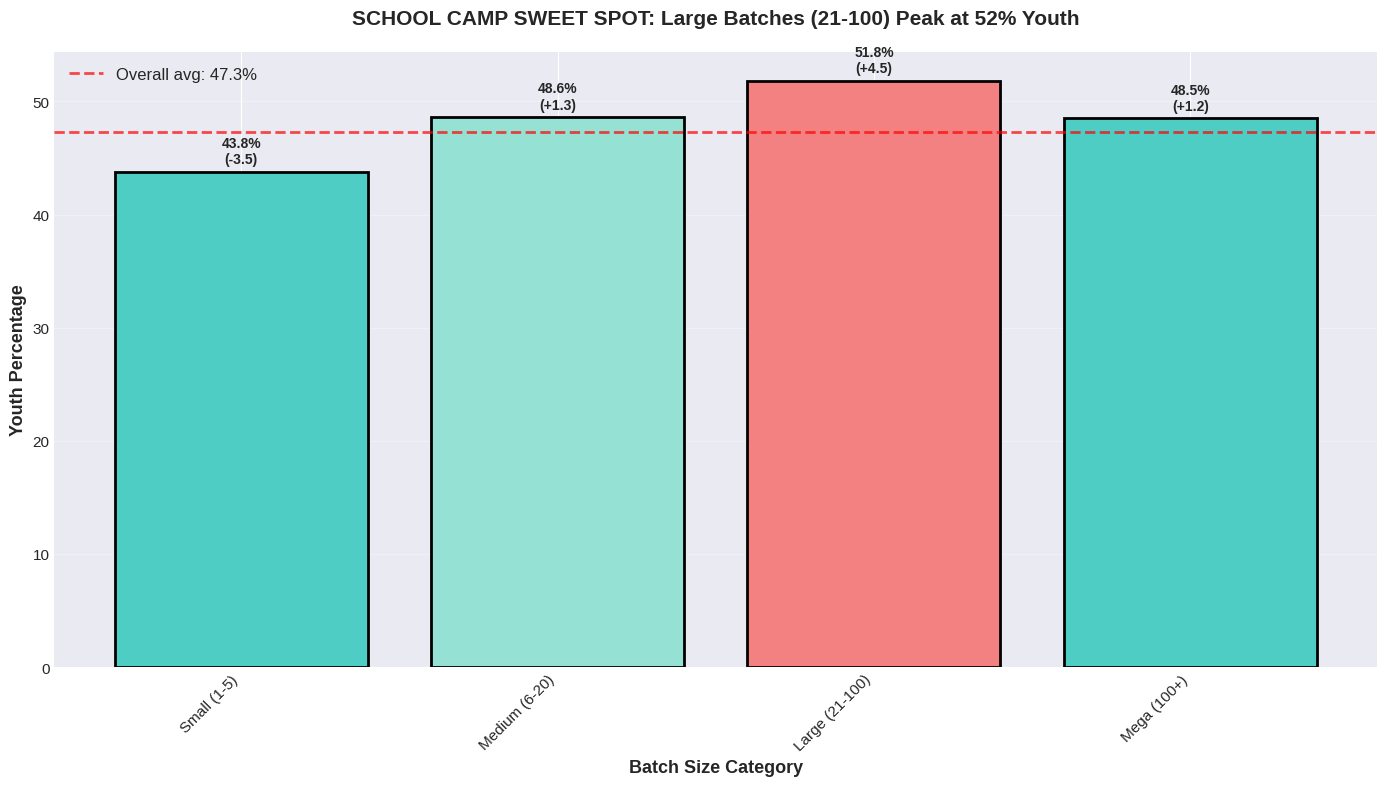


Creating Visualization 2: Weekend Family Access Pattern...
  ✓ Saved: biom_viz_2_weekend_pattern.png


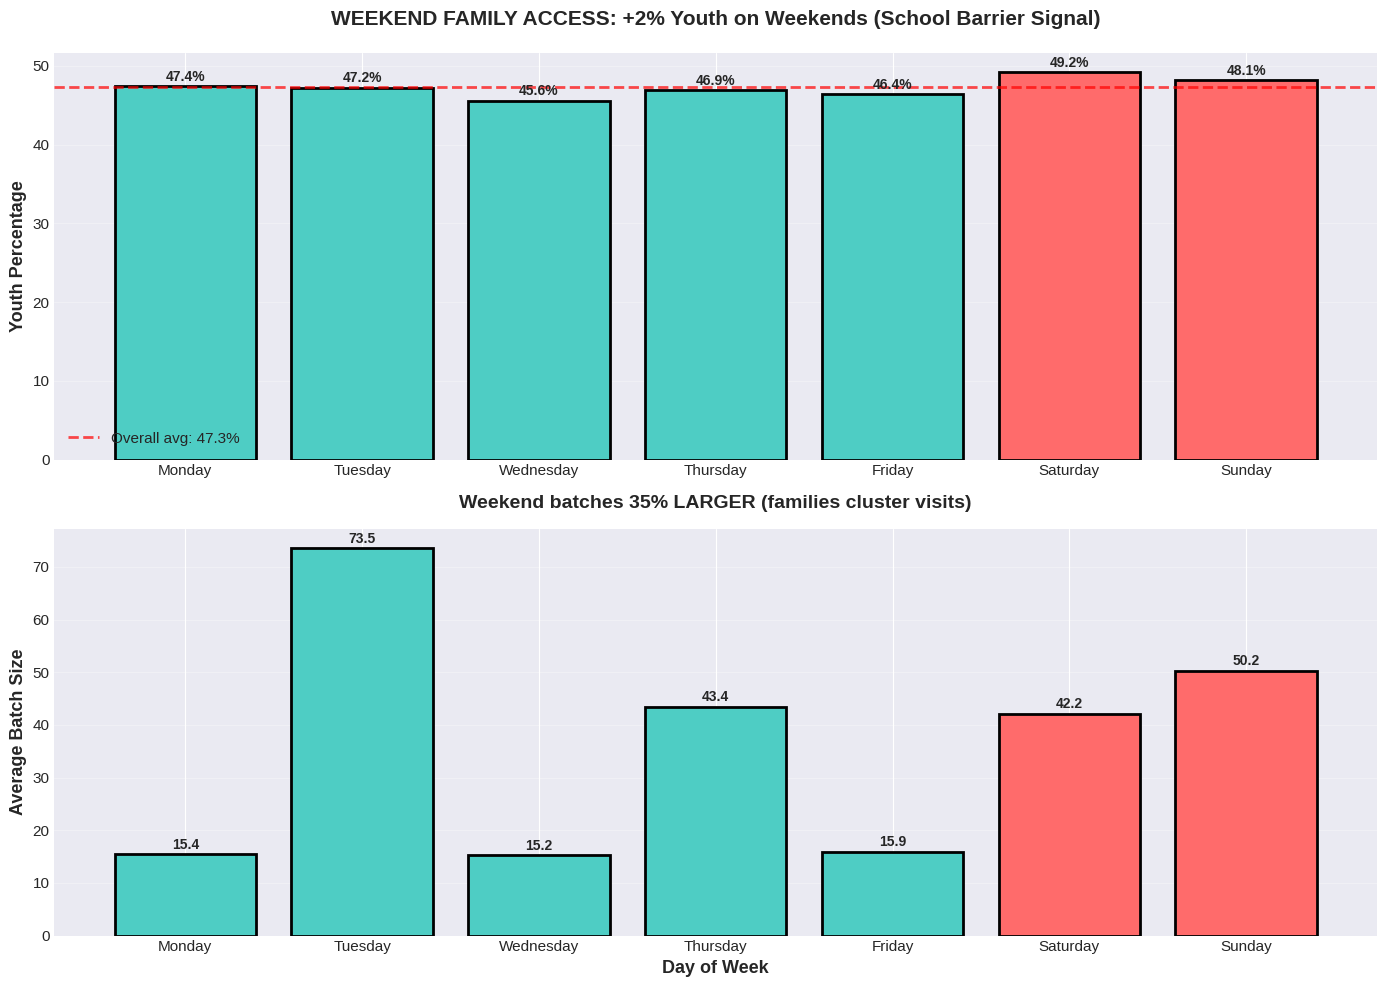


Creating Visualization 3: Geographic Youth Biometric Pressure...
  ✓ Saved: biom_viz_3_geographic_youth.png


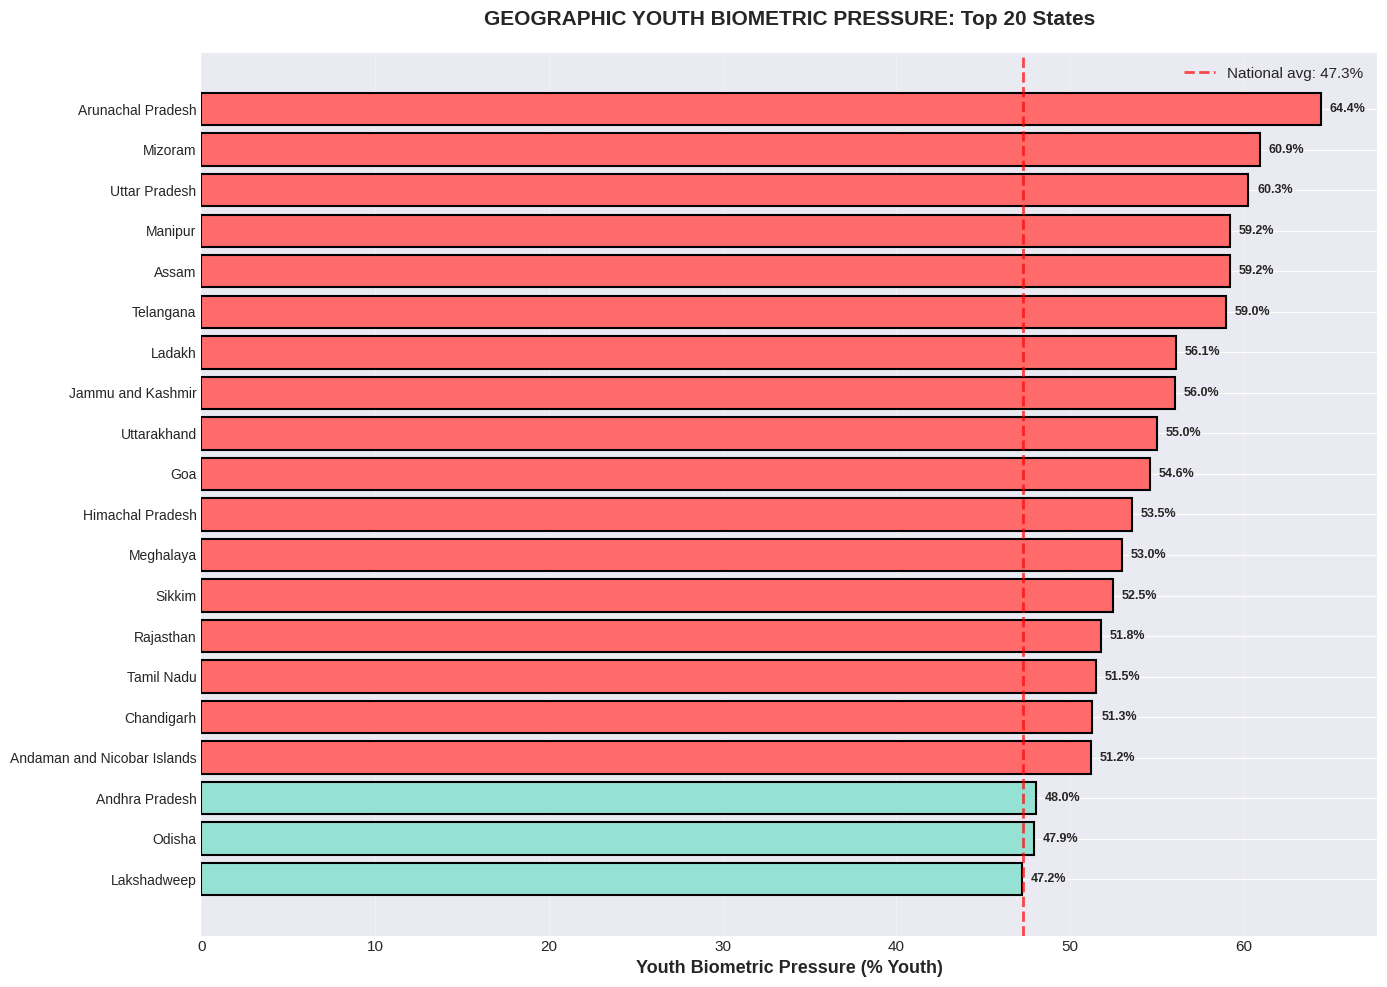


Creating Visualization 4: Youth Biometric Temporal Stability...
  ✓ Saved: biom_viz_4_youth_temporal.png


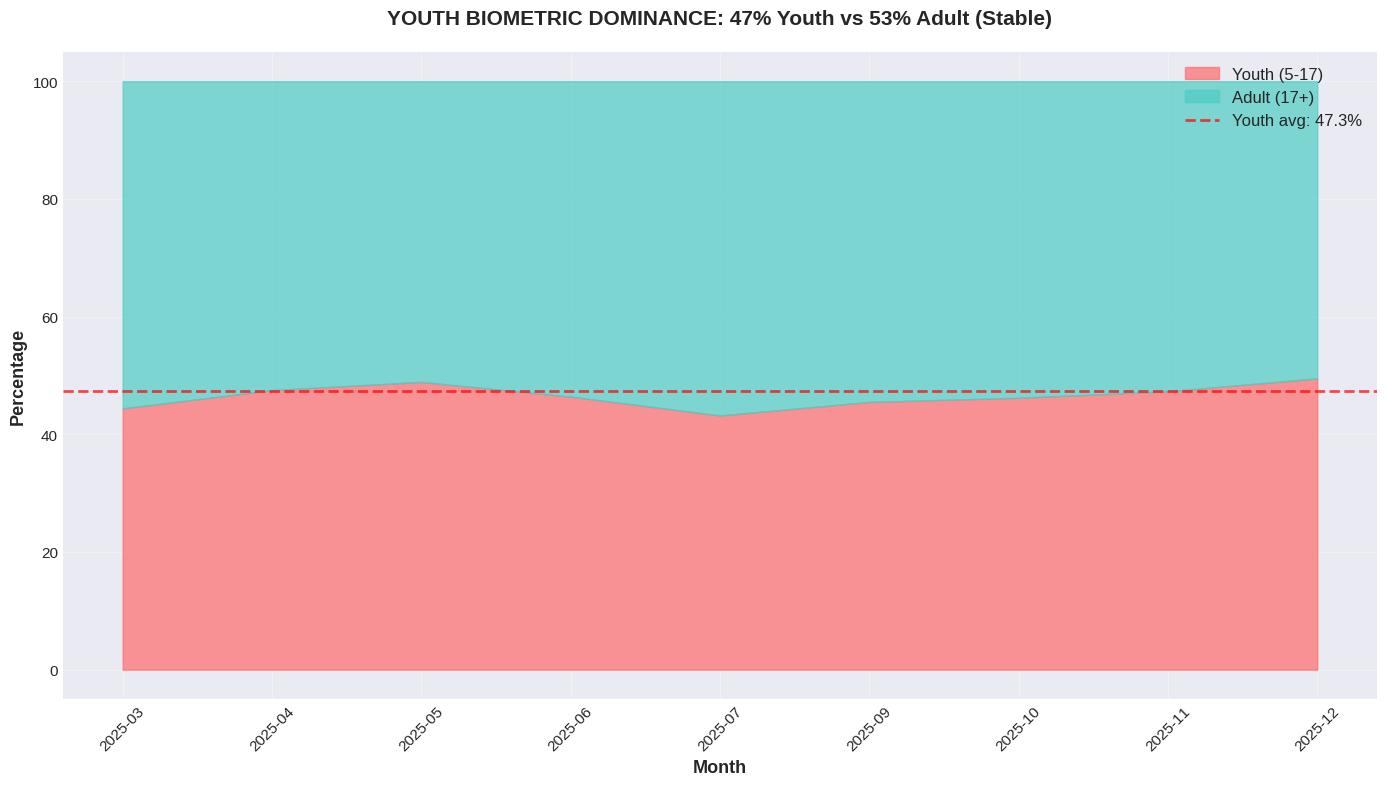


Creating Visualization 5: Biometric vs Demographic Youth Service Divide...
  ✓ Saved: biom_viz_5_service_divide.png


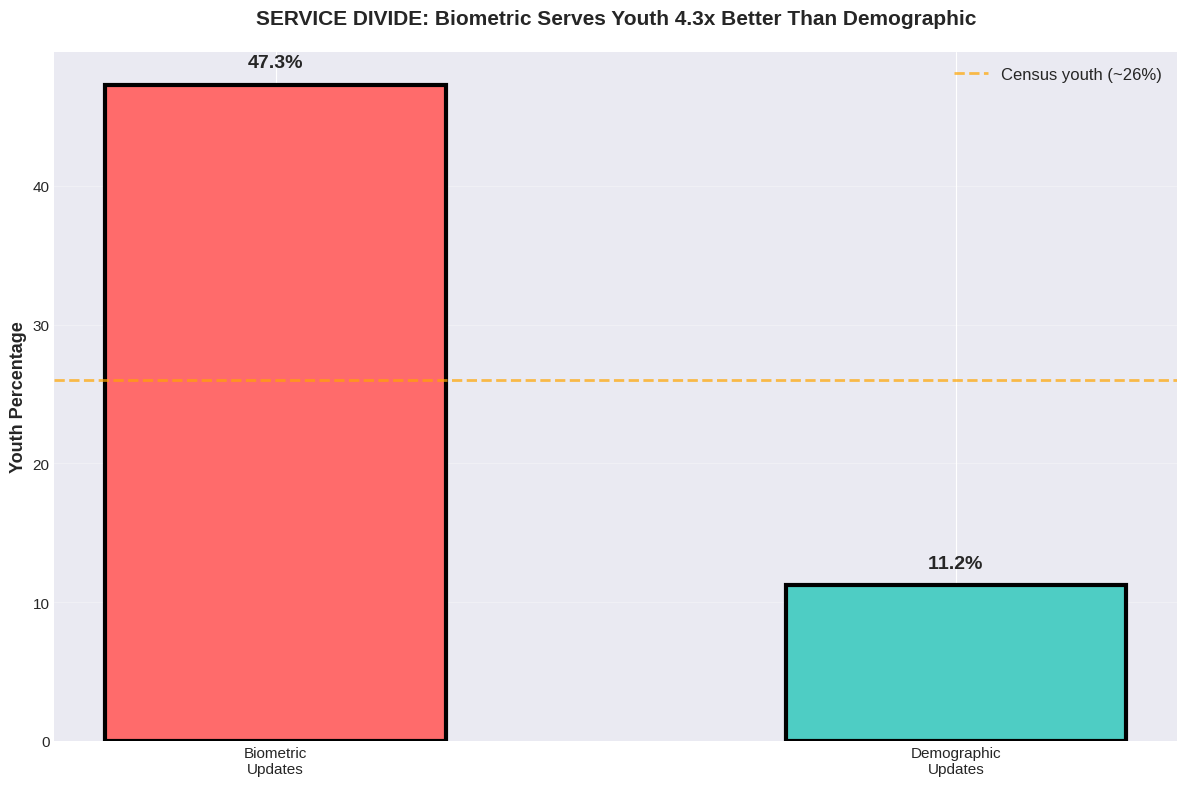


✅ ALL BIOMETRIC VISUALIZATIONS CREATED!

DOWNLOAD FILES



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 BIOMETRIC ANALYSIS COMPLETE!

You now have:
  ✓ 5 publication-quality visualizations (PNG, 300 DPI)
  ✓ Processed full dataset with derived features
  ✓ Biometric statistics in JSON format
  ✓ All 7 lifecycle insights ready for presentation

Key Messages:
   47% youth dominance (vs 11% demographic)
   52% youth peak in large batches (optimal school camps)
   +2.0% weekend youth (family access constraint)
   1.8x geographic disparity (vs 3.7x demographic)


In [17]:
print("\n" + "="*80)
print("CREATING BIOMETRIC VISUALIZATIONS")
print("="*80)

# VIZ 1: Batch Size vs Youth % (Sweet Spot Curve)
print("\nCreating Visualization 1: School Camp Sweet Spot...")

fig, ax = plt.subplots(figsize=(14, 8))

batch_cats = age_by_batch.index
youth_pcts = age_by_batch['Avg_%_Youth']
colors = ['#4ECDC4', '#95E1D3', '#F38181', '#4ECDC4']

bars = ax.bar(range(len(batch_cats)), youth_pcts, color=colors,
             edgecolor='black', linewidth=2)

ax.axhline(overall_youth_pct, color='red', linestyle='--', linewidth=2,
          label=f'Overall avg: {overall_youth_pct:.1f}%', alpha=0.7)

ax.set_xticks(range(len(batch_cats)))
ax.set_xticklabels(batch_cats, rotation=45, ha='right')
ax.set_xlabel('Batch Size Category', fontsize=13, fontweight='bold')
ax.set_ylabel('Youth Percentage', fontsize=13, fontweight='bold')
ax.set_title('SCHOOL CAMP SWEET SPOT: Large Batches (21-100) Peak at 52% Youth',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars, youth_pcts):
    height = bar.get_height()
    delta = pct - overall_youth_pct
    label = f'{pct:.1f}%\n({delta:+.1f})'
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           label, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('biom_viz_1_batch_sweet_spot.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: biom_viz_1_batch_sweet_spot.png")
plt.show()

# VIZ 2: Weekend vs Weekday Pattern (Dual-Panel)
print("\nCreating Visualization 2: Weekend Family Access Pattern...")

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_youth = df.groupby('day_of_week')['pct_age_5_17'].mean().reindex(dow_order)
dow_batch = df.groupby('day_of_week')['total_biometric'].mean().reindex(dow_order)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Youth percentage
colors = ['#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4', '#FF6B6B', '#FF6B6B']
bars1 = ax1.bar(dow_order, dow_youth, color=colors, edgecolor='black', linewidth=2)
ax1.axhline(overall_youth_pct, color='red', linestyle='--', linewidth=2,
           label=f'Overall avg: {overall_youth_pct:.1f}%', alpha=0.7)
ax1.set_ylabel('Youth Percentage', fontsize=13, fontweight='bold')
ax1.set_title('WEEKEND FAMILY ACCESS: +2% Youth on Weekends (School Barrier Signal)',
             fontsize=15, fontweight='bold', pad=20)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars1, dow_youth):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
           f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Batch size
bars2 = ax2.bar(dow_order, dow_batch, color=colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax2.set_ylabel('Average Batch Size', fontsize=13, fontweight='bold')
ax2.set_title('Weekend batches 35% LARGER (families cluster visits)',
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

for bar, size in zip(bars2, dow_batch):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           f'{size:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('biom_viz_2_weekend_pattern.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: biom_viz_2_weekend_pattern.png")
plt.show()

# VIZ 3: Geographic Youth Disparity
print("\nCreating Visualization 3: Geographic Youth Biometric Pressure...")

fig, ax = plt.subplots(figsize=(14, 10))

state_youth_plot = state_youth.sort_values(ascending=True).tail(20)
colors_youth = ['#4ECDC4' if x < 45 else '#95E1D3' if x < 50 else '#FF6B6B'
                for x in state_youth_plot]

bars = ax.barh(range(len(state_youth_plot)), state_youth_plot,
              color=colors_youth, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(state_youth_plot)))
ax.set_yticklabels(state_youth_plot.index, fontsize=10)
ax.set_xlabel('Youth Biometric Pressure (% Youth)', fontsize=13, fontweight='bold')
ax.set_title('GEOGRAPHIC YOUTH BIOMETRIC PRESSURE: Top 20 States',
            fontsize=15, fontweight='bold', pad=20)
ax.axvline(overall_youth_pct, color='red', linestyle='--', linewidth=2,
          label=f'National avg: {overall_youth_pct:.1f}%', alpha=0.7)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, state_youth_plot):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
           f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('biom_viz_3_geographic_youth.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: biom_viz_3_geographic_youth.png")
plt.show()

# VIZ 4: Youth Dominance Over Time
print("\nCreating Visualization 4: Youth Biometric Temporal Stability...")

monthly_youth = df.groupby('year_month').agg({
    'pct_age_5_17': 'mean',
    'pct_age_17_above': 'mean'
}).round(1)

fig, ax = plt.subplots(figsize=(14, 8))

months = monthly_youth.index
x = range(len(months))

ax.fill_between(x, 0, monthly_youth['pct_age_5_17'],
               label='Youth (5-17)', alpha=0.7, color='#FF6B6B')
ax.fill_between(x, monthly_youth['pct_age_5_17'], 100,
               label='Adult (17+)', alpha=0.7, color='#4ECDC4')

ax.axhline(overall_youth_pct, color='red', linestyle='--', linewidth=2,
          label=f'Youth avg: {overall_youth_pct:.1f}%', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.set_xlabel('Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=13, fontweight='bold')
ax.set_title('YOUTH BIOMETRIC DOMINANCE: 47% Youth vs 53% Adult (Stable)',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('biom_viz_4_youth_temporal.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: biom_viz_4_youth_temporal.png")
plt.show()

# VIZ 5: Biometric vs Demographic Comparison
print("\nCreating Visualization 5: Biometric vs Demographic Youth Service Divide...")

fig, ax = plt.subplots(figsize=(12, 8))

services = ['Biometric\nUpdates', 'Demographic\nUpdates']
youth_pcts_compare = [overall_youth_pct, 11.2]  # 11.2% from demographic analysis
colors_compare = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(services, youth_pcts_compare, color=colors_compare,
             edgecolor='black', linewidth=3, width=0.5)

ax.axhline(26, color='orange', linestyle='--', linewidth=2,
          label='Census youth (~26%)', alpha=0.7)

ax.set_ylabel('Youth Percentage', fontsize=13, fontweight='bold')
ax.set_title('SERVICE DIVIDE: Biometric Serves Youth 4.3x Better Than Demographic',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars, youth_pcts_compare):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{pct:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('biom_viz_5_service_divide.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: biom_viz_5_service_divide.png")
plt.show()

print("\n" + "="*80)
print("✅ ALL BIOMETRIC VISUALIZATIONS CREATED!")
print("="*80)

# ============================================================================
# CELL 16: DOWNLOAD RESULTS
# ============================================================================

print("\n" + "="*80)
print("DOWNLOAD FILES")
print("="*80)

from google.colab import files

# Download visualizations
print("\nDownloading visualizations...")
files.download('biom_viz_1_batch_sweet_spot.png')
files.download('biom_viz_2_weekend_pattern.png')
files.download('biom_viz_3_geographic_youth.png')
files.download('biom_viz_4_youth_temporal.png')
files.download('biom_viz_5_service_divide.png')

# Save processed data
df.to_csv('biometric_processed_full.csv', index=False)
print("\nDownloading processed data...")
files.download('biometric_processed_full.csv')

# Save summary statistics
import json
biom_summary = {
    'overall_youth_pct': float(overall_youth_pct),
    'overall_adult_pct': float(overall_adult_pct),
    'weekend_surplus': float(weekend_surplus),
    'september_youth_shift': float(youth_shift) if len(pre_sep) > 0 else None,
    'geographic_disparity': float(disparity),
    'large_batch_youth_peak': float(large_youth),
    'volume_shift': float(volume_shift) if len(pre_sep) > 0 else None,
    'total_records': int(len(df)),
    'total_captures': int(df['total_biometric'].sum())
}

with open('biometric_statistics.json', 'w') as f:
    json.dump(biom_summary, f, indent=2)

print("\nDownloading statistics...")
files.download('biometric_statistics.json')

print("\n" + "="*80)
print(" BIOMETRIC ANALYSIS COMPLETE!")
print("="*80)
print("\nYou now have:")
print("  ✓ 5 publication-quality visualizations (PNG, 300 DPI)")
print("  ✓ Processed full dataset with derived features")
print("  ✓ Biometric statistics in JSON format")
print("  ✓ All 7 lifecycle insights ready for presentation")
print("\nKey Messages:")
print(f"   {overall_youth_pct:.0f}% youth dominance (vs 11% demographic)")
print(f"   {large_youth:.0f}% youth peak in large batches (optimal school camps)")
print(f"   +{weekend_surplus:.1f}% weekend youth (family access constraint)")
print(f"   {disparity:.1f}x geographic disparity (vs 3.7x demographic)")
